Note: Most code is copied from: https://www.kaggle.com/code/terencicp/steam-games-data-transformation

In [1]:
import pandas as pd
import json
import numpy as np
from datetime import datetime

Load json version of games dataset

In [2]:
first_file = '../data/games.json'
with open(first_file, 'r', encoding="utf8") as file:
    json_data = json.load(file)

Drop unneeded variables

In [3]:
dropped = [
    'packages', 'screenshots', 'movies', 'score_rank', 'header_image',
    'reviews', 'website', 'support_url', 'notes', 'support_email',
    'median_playtime_2weeks', 'required_age',
    'metacritic_url', 'detailed_description', 'about_the_game', 
    'average_playtime_2weeks'
]

In [4]:
# Process each game's information and store in a list
games = [{
    **{k: v for k, v in game_info.items() if k not in dropped},
    'tags': list(tags.keys()) if isinstance((tags := game_info.get('tags', {})), dict) else [],
    'tag_frequencies': list(tags.values()) if isinstance(tags, dict) else [],
    'app_id': app_id
} for app_id, game_info in json_data.items()]

# Create a DataFrame from the processed list
df = pd.DataFrame(games)
df

,name,release_date,price,dlc_count,short_description,windows,mac,linux,metacritic_score,achievements,...,user_score,positive,negative,estimated_owners,average_playtime_forever,median_playtime_forever,peak_ccu,tags,tag_frequencies,app_id
0,Galactic Bowling,"Oct 21, 2008",19.99,0,Galactic Bowling is an exaggerated and stylize...,True,False,False,0,30,...,0,6,11,0 - 20000,0,0,0,"[Indie, Casual, Sports, Bowling]","[22, 21, 21, 6]",20200
1,Train Bandit,"Oct 12, 2017",0.99,0,THE LAW!! Looks to be a showdown atop a train....,True,True,False,0,12,...,0,53,5,0 - 20000,0,0,0,"[Indie, Action, Pixel Graphics, 2D, Retro, Arc...","[109, 103, 100, 97, 93, 86, 84, 82, 76, 69, 65...",655370
2,Jolt Project,"Nov 17, 2021",4.99,0,"Shoot vehicles, blow enemies with a special at...",True,False,False,0,0,...,0,0,0,0 - 20000,0,0,0,[],[],1732930
3,Henosis™,"Jul 23, 2020",5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,True,True,True,0,0,...,0,3,0,0 - 20000,0,0,0,"[2D Platformer, Atmospheric, Surreal, Mystery,...","[161, 154, 151, 145, 139, 128, 126, 122, 115, ...",1355720
4,Two Weeks in Painland,"Feb 3, 2020",0.00,0,Two Weeks in Painland is a story-driven game a...,True,True,False,0,17,...,0,50,8,0 - 20000,0,0,0,"[Indie, Adventure, Nudity, Violent, Sexual Con...","[42, 41, 22, 21, 21, 11]",1139950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85098,Mannerheim's Saloon Car,"Jan 2, 2024",0.00,0,Explore Mannerheim’s historical train carriage...,True,False,False,0,0,...,0,0,0,0 - 0,0,0,0,[],[],2669080
85099,Beer Run,"Jan 3, 2024",0.00,0,Beer Run is an Indie game created to steal bee...,True,False,False,0,0,...,0,0,0,0 - 0,0,0,0,[],[],2736910
85100,My Friend The Spider,"Jan 4, 2024",0.00,0,A small 'horror' narrative game about isolatio...,True,False,False,0,0,...,0,0,0,0 - 0,0,0,0,[],[],2743220
85101,Path of Survivors,"Jan 8, 2024",3.99,0,"Unlock new heroes and abilities, collect and c...",True,False,False,0,34,...,0,0,0,0 - 0,0,0,0,[],[],2293130


## Data Cleaning

Remove games with no sales:

In [5]:
count = (df['estimated_owners'] == "0 - 0").sum()
print("Number of games with estimated owners '0 - 0':", count)

Number of games with estimated owners '0 - 0': 11504


In [6]:
df[df['estimated_owners'] == "0 - 0"]

,name,release_date,price,dlc_count,short_description,windows,mac,linux,metacritic_score,achievements,...,user_score,positive,negative,estimated_owners,average_playtime_forever,median_playtime_forever,peak_ccu,tags,tag_frequencies,app_id
53,Eternal Edge+ Prologue,"May 5, 2022",0.00,0,Eternal Edge + is a casual Action-Adventure ro...,True,False,False,0,0,...,0,0,0,0 - 0,0,0,0,[],[],1959480
95,Moon Farming - Prologue,"Jan 6, 2022",0.00,0,Tired from the same farming games on Earth? No...,True,False,False,0,7,...,0,0,0,0 - 0,0,0,0,[],[],1662060
105,溪风谷之战 Playtest,"Mar 24, 2022",0.00,0,,True,False,False,0,0,...,0,0,0,0 - 0,0,0,0,[],[],1943590
106,Deer Journey,"Jul 21, 2022",5.39,0,Deer Journey is a third person walking simulat...,True,False,False,0,2,...,0,0,0,0 - 0,0,0,0,[],[],1995240
180,Burial Stone Playtest,"Apr 13, 2022",0.00,0,,True,False,False,0,0,...,0,0,0,0 - 0,0,0,0,[],[],1966960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85098,Mannerheim's Saloon Car,"Jan 2, 2024",0.00,0,Explore Mannerheim’s historical train carriage...,True,False,False,0,0,...,0,0,0,0 - 0,0,0,0,[],[],2669080
85099,Beer Run,"Jan 3, 2024",0.00,0,Beer Run is an Indie game created to steal bee...,True,False,False,0,0,...,0,0,0,0 - 0,0,0,0,[],[],2736910
85100,My Friend The Spider,"Jan 4, 2024",0.00,0,A small 'horror' narrative game about isolatio...,True,False,False,0,0,...,0,0,0,0 - 0,0,0,0,[],[],2743220
85101,Path of Survivors,"Jan 8, 2024",3.99,0,"Unlock new heroes and abilities, collect and c...",True,False,False,0,34,...,0,0,0,0 - 0,0,0,0,[],[],2293130


Some games just seem to be developer tests. Let's remove them. We'll also remove games with no reviews or no categories:

In [7]:
# Filter games without sales, reviews or categories
df2 = df[~((df['estimated_owners'] == "0 - 0") | (df['positive'] + df['negative'] == 0) | (df['categories'].str.len() == 0))]

Let's see the DataFrame again. It seems we got rid of more than 20000 irrelevant games:

In [8]:
df2.shape

(63008, 27)

I'll also split the 'estimated_owners' column into two different variables, this way we'll be able to use it for aggregation in Tableau:

In [9]:
# Split estimated_owners into two: min_owners and max_owners
df2[['min_owners', 'max_owners']] = df2['estimated_owners'].str.split(' - ', expand=True)

# Remove the original field
df2 = df2.drop('estimated_owners', axis=1)

C:\Users\laure\AppData\Local\Temp\ipykernel_5644\2812893516.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['min_owners', 'max_owners']] = df2['estimated_owners'].str.split(' - ', expand=True)
C:\Users\laure\AppData\Local\Temp\ipykernel_5644\2812893516.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['min_owners', 'max_owners']] = df2['estimated_owners'].str.split(' - ', expand=True)


In [10]:
df2[['min_owners', 'max_owners']]

,min_owners,max_owners
0,0,20000
1,0,20000
3,0,20000
4,0,20000
5,50000,100000
...,...,...
85077,0,20000
85079,0,20000
85083,0,20000
85085,0,20000


Let's have a look at the distribution of prices:

<Axes: >

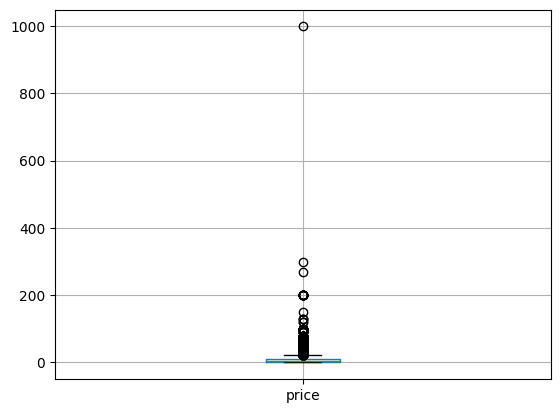

In [11]:
# Box plot of price
df2.boxplot(column=['price'])

In [12]:
# Games priced above 200$
df2[df2['price'] > 200]

,name,release_date,price,dlc_count,short_description,windows,mac,linux,metacritic_score,achievements,...,positive,negative,average_playtime_forever,median_playtime_forever,peak_ccu,tags,tag_frequencies,app_id,min_owners,max_owners
26936,Ascent Free-Roaming VR Experience,"Dec 27, 2019",999.00,0,A premium highly-immersive VR experience devel...,True,False,False,0,0,...,6,0,0,0,0,"[Action, VR, Free to Play, Multiplayer, Arena ...","[82, 14, 12, 12, 11, 10, 10, 10, 9, 6, 6]",1200520,0,20000
32110,Houdini Indie,"Oct 10, 2018",269.99,0,Houdini Indie's procedural node-based workflow...,True,True,False,0,0,...,141,7,0,0,59,"[Animation & Modeling, Game Development, 3D, D...","[61, 58, 40, 37, 21, 14, 11]",502570,0,20000
57689,Aartform Curvy 3D 3.0,"Nov 12, 2013",299.90,0,Curvy 3D 3.0 is an innovative sculpting progra...,True,False,False,0,0,...,32,13,150,150,0,[Animation & Modeling],[24],253670,0,20000


We can see that the game priced at $999 is basically a cash-grab without any actual sales, and being an extreme outlier it can distort our analysis. Let's remove it:

In [13]:
# Delete game with id 26936
df2 = df2[df2['app_id'] != 26936]

In [14]:
df2

,name,release_date,price,dlc_count,short_description,windows,mac,linux,metacritic_score,achievements,...,positive,negative,average_playtime_forever,median_playtime_forever,peak_ccu,tags,tag_frequencies,app_id,min_owners,max_owners
0,Galactic Bowling,"Oct 21, 2008",19.99,0,Galactic Bowling is an exaggerated and stylize...,True,False,False,0,30,...,6,11,0,0,0,"[Indie, Casual, Sports, Bowling]","[22, 21, 21, 6]",20200,0,20000
1,Train Bandit,"Oct 12, 2017",0.99,0,THE LAW!! Looks to be a showdown atop a train....,True,True,False,0,12,...,53,5,0,0,0,"[Indie, Action, Pixel Graphics, 2D, Retro, Arc...","[109, 103, 100, 97, 93, 86, 84, 82, 76, 69, 65...",655370,0,20000
3,Henosis™,"Jul 23, 2020",5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,True,True,True,0,0,...,3,0,0,0,0,"[2D Platformer, Atmospheric, Surreal, Mystery,...","[161, 154, 151, 145, 139, 128, 126, 122, 115, ...",1355720,0,20000
4,Two Weeks in Painland,"Feb 3, 2020",0.00,0,Two Weeks in Painland is a story-driven game a...,True,True,False,0,17,...,50,8,0,0,0,"[Indie, Adventure, Nudity, Violent, Sexual Con...","[42, 41, 22, 21, 21, 11]",1139950,0,20000
5,Wartune Reborn,"Feb 26, 2021",0.00,0,'Wartune Reborn' epic magic TBS game was devel...,True,False,False,0,0,...,87,49,0,0,68,"[Turn-Based Combat, Massively Multiplayer, Mul...","[292, 290, 282, 281, 277, 275, 271, 264, 259, ...",1469160,50000,100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85077,Ant Farm Simulator,"Jan 5, 2024",0.99,0,Ant farm (formicarium) with a colony of ants. ...,True,False,False,0,0,...,1,1,0,0,3,"[Simulation, Casual, Sandbox, Farming Sim, Lif...","[72, 66, 43, 40, 37, 31, 30, 27, 25, 23, 21, 2...",2704060,0,20000
85079,The Holyburn Witches,"Jan 5, 2024",2.99,0,An atmospheric survival-horror game made from ...,True,True,False,0,0,...,1,3,0,0,0,"[Casual, Adventure, Point & Click, Exploration...","[71, 44, 41, 39, 36, 30, 27, 26, 24, 22, 21, 2...",2645600,0,20000
85083,Digital Girlfriend,"Jan 5, 2024",3.74,1,《Digital Girlfriend》 is a nurturing game of su...,True,False,False,0,0,...,8,7,0,0,0,"[Casual, Sexual Content, Nudity, Adventure, Ma...","[129, 125, 121, 116, 114, 110, 105, 104, 99, 9...",2464700,0,20000
85085,Above the Hill,"Jan 5, 2024",8.49,0,A hicker twists his foot in a dangerous curve ...,True,False,False,0,11,...,2,1,0,0,0,"[Adventure, Action-Adventure, Exploration, FPS...","[71, 45, 42, 39, 36, 30, 28, 26, 24, 22, 21, 2...",2602790,0,20000


## Normalizing data

The DataFrame contains fields such as 'categories' or 'tags' that consist on lists of values. To improve the performance of the visualization we'll build in Tableau we must convert this fields into separate tables, that will be linked with the main table using the 'app_id' column.

In [15]:
# Create a separate DataFrame for each list-type column
cols = ["supported_languages", "full_audio_languages", "categories", "genres"]
for col in cols:
    new_df = df2.explode(col)[['app_id', col]]
    new_df.to_csv(f'../data/{col}.csv', index=False)

df_tags = df2.explode('tags')[['app_id', 'tags']]
df_frequencies = df2.explode('tag_frequencies')['tag_frequencies']
df_tags['tag_frequencies'] = df_frequencies.values

# Remove the list columns from the main DataFrame
columns_to_remove = cols + ['tags', 'tag_frequencies']
df_imploded = df2.drop(columns=columns_to_remove)

In [16]:
df_imploded

,name,release_date,price,dlc_count,short_description,windows,mac,linux,metacritic_score,achievements,...,publishers,user_score,positive,negative,average_playtime_forever,median_playtime_forever,peak_ccu,app_id,min_owners,max_owners
0,Galactic Bowling,"Oct 21, 2008",19.99,0,Galactic Bowling is an exaggerated and stylize...,True,False,False,0,30,...,[Perpetual FX Creative],0,6,11,0,0,0,20200,0,20000
1,Train Bandit,"Oct 12, 2017",0.99,0,THE LAW!! Looks to be a showdown atop a train....,True,True,False,0,12,...,[Wild Rooster],0,53,5,0,0,0,655370,0,20000
3,Henosis™,"Jul 23, 2020",5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,True,True,True,0,0,...,[Odd Critter Games],0,3,0,0,0,0,1355720,0,20000
4,Two Weeks in Painland,"Feb 3, 2020",0.00,0,Two Weeks in Painland is a story-driven game a...,True,True,False,0,17,...,[Unusual Games],0,50,8,0,0,0,1139950,0,20000
5,Wartune Reborn,"Feb 26, 2021",0.00,0,'Wartune Reborn' epic magic TBS game was devel...,True,False,False,0,0,...,[7Road],0,87,49,0,0,68,1469160,50000,100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85077,Ant Farm Simulator,"Jan 5, 2024",0.99,0,Ant farm (formicarium) with a colony of ants. ...,True,False,False,0,0,...,[Smirna Simulator Games],0,1,1,0,0,3,2704060,0,20000
85079,The Holyburn Witches,"Jan 5, 2024",2.99,0,An atmospheric survival-horror game made from ...,True,True,False,0,0,...,[Moolion],0,1,3,0,0,0,2645600,0,20000
85083,Digital Girlfriend,"Jan 5, 2024",3.74,1,《Digital Girlfriend》 is a nurturing game of su...,True,False,False,0,0,...,[4XPet],0,8,7,0,0,0,2464700,0,20000
85085,Above the Hill,"Jan 5, 2024",8.49,0,A hicker twists his foot in a dangerous curve ...,True,False,False,0,11,...,[M.Mustapha Hadi],0,2,1,0,0,0,2602790,0,20000


## Save results as CSV

Dataset that doesn't include list-like columns

In [17]:
df_imploded.to_csv('../data/cleaned_games.csv', index=False)